# Загрузка данных

Импорт и установка библиотек

In [ ]:
!pip install pmdarima
!pip install numpy==1.26.0
!pip install --upgrade tensorflow


import pickle
import warnings
import requests
import statsmodels
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from io import BytesIO
from datetime import datetime
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import acf, adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error


warnings.filterwarnings("ignore")
%matplotlib inline

Выберите способ загрузки данных

In [ ]:
url = "https://github.com/samoletpanfilov/reinforcement_task/raw/refs/heads/master/data/train.xlsx"  # Ссылка должна содержать raw
response = requests.get(url)
df_ts = pd.read_excel(BytesIO(response.content), engine='openpyxl')

In [ ]:
# df_ts = pd.read_excel('/content/drive/MyDrive/int/train.xlsx')

# Анализ и предобработка

### просмотр статистической информации

In [ ]:
df_ts.head(15)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
5,2015-02-09,30300
6,2015-02-16,30100
7,2015-02-23,29400
8,2015-03-02,29200
9,2015-03-09,29000


In [ ]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [ ]:
# Проверка на наличие NaN
df_ts['dt'].isna().sum()

0

In [ ]:
df_ts.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [ ]:
df_ts.shape

(400, 2)

### Визуализация

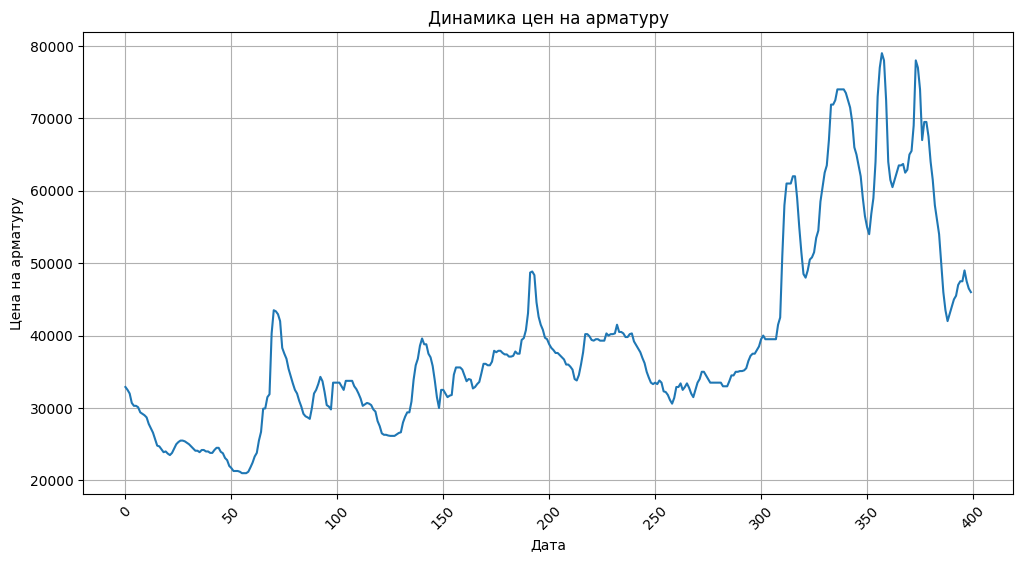

In [ ]:
# Строим график
plt.figure(figsize=(12, 6))
plt.plot(df_ts["Цена на арматуру"], marker='', linestyle='-')

# Настроим оси и заголовок
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Динамика цен на арматуру")
plt.grid(True)

# Улучшим читаемость меток дат
plt.xticks(rotation=45)

# Показываем график
plt.show()

**Вопросы к графику:**

 1.Есть ли тренд?

 2.Есть ли сезонность?

 3.Насколько сильный шум?



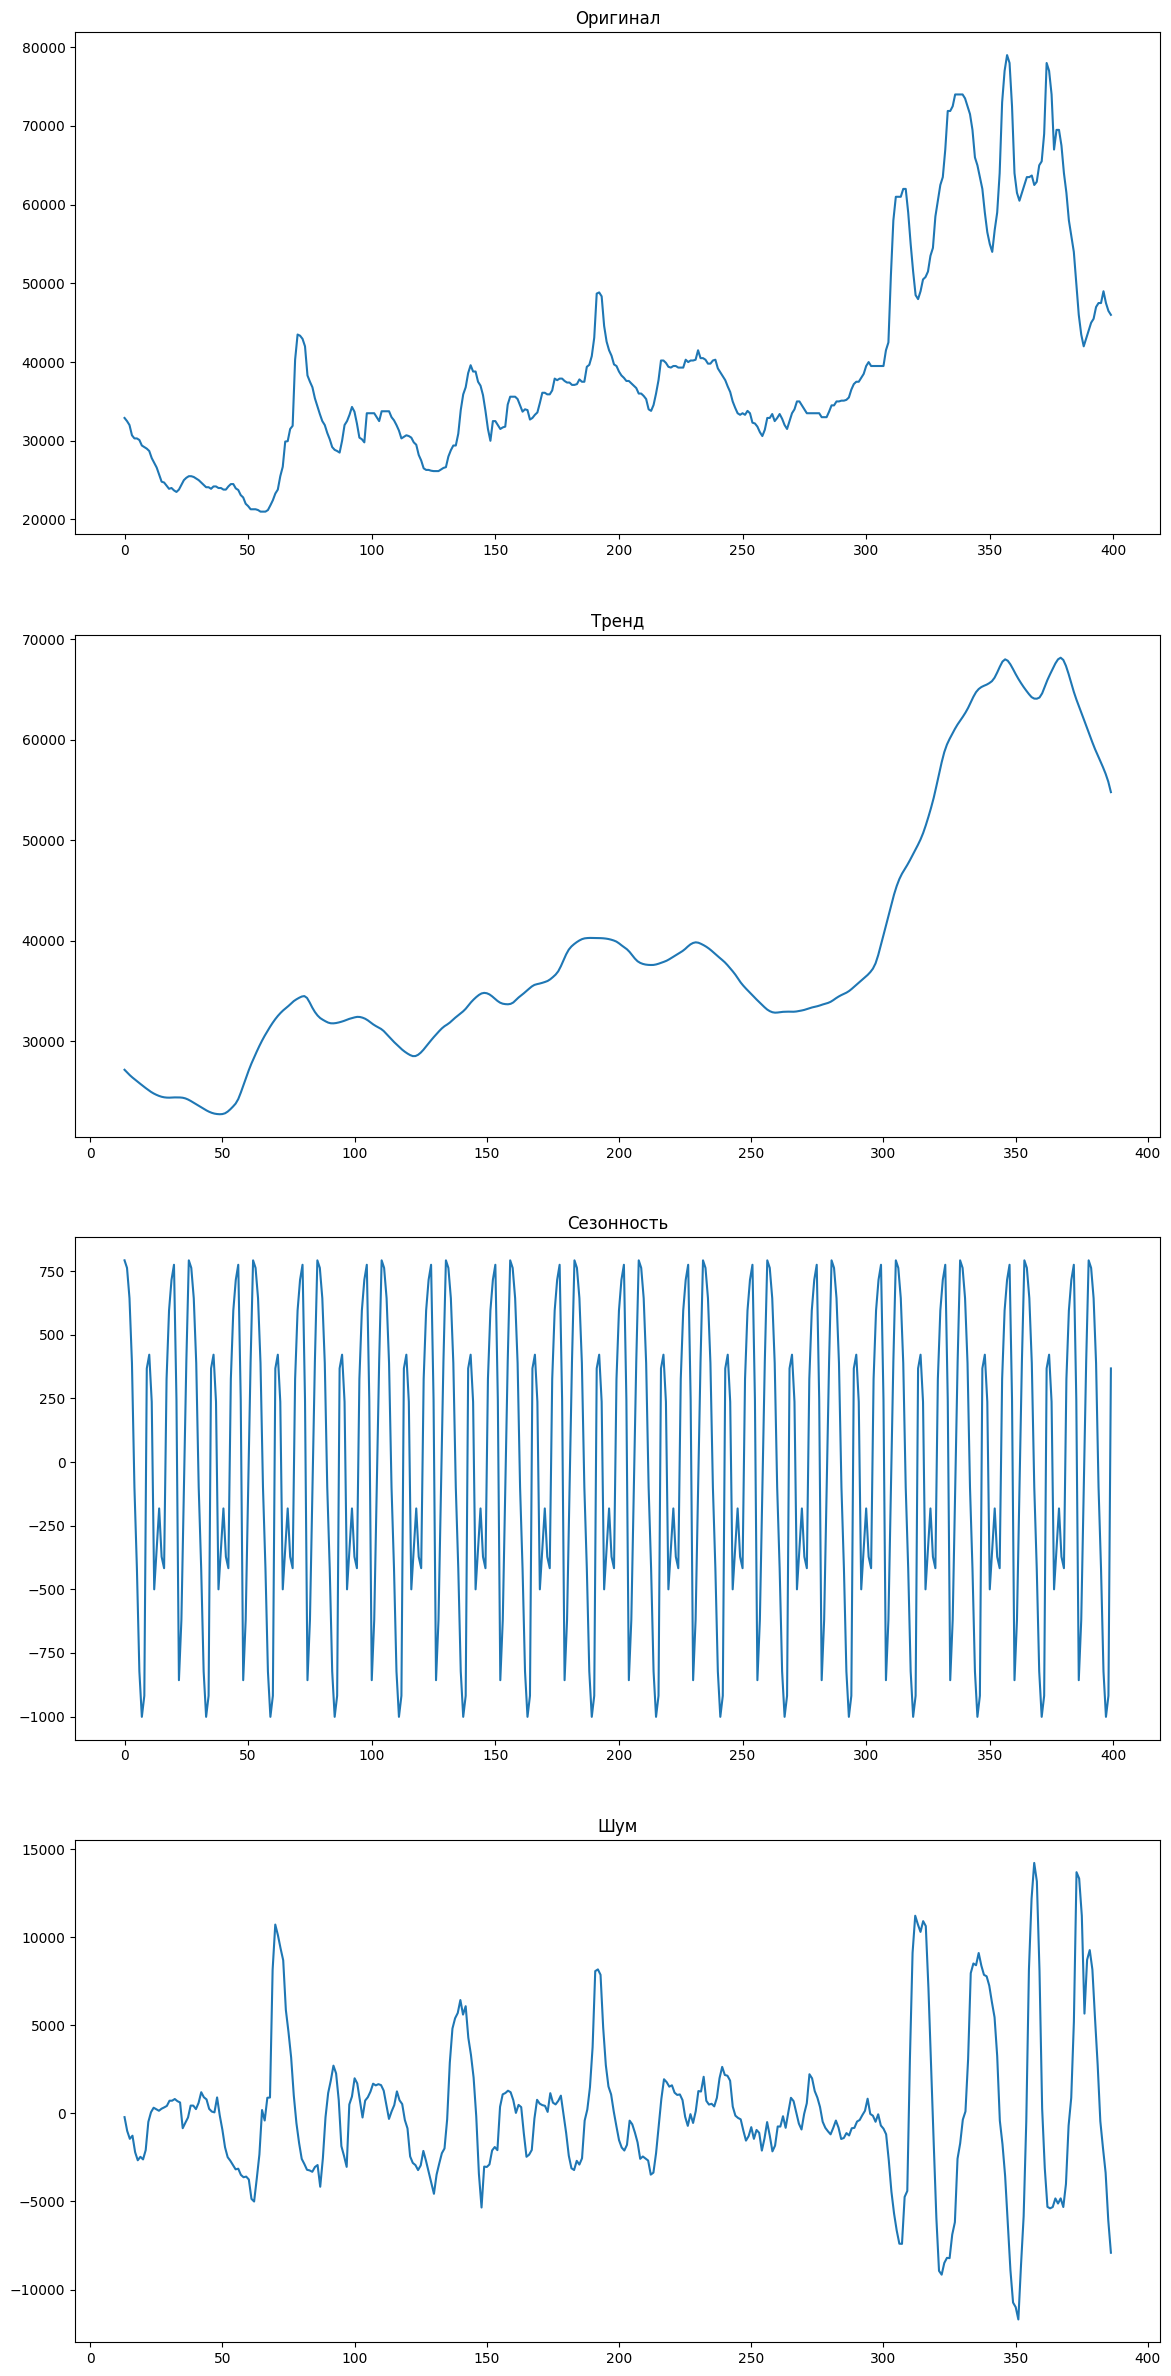

In [ ]:
# Разложим ряд на компоненты и проверим ответы на вопросы

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 30))
decompose = seasonal_decompose(df_ts['Цена на арматуру'],period = 26)

ax[0].set_title('Оригинал')
ax[1].set_title('Тренд')
ax[2].set_title('Сезонность')
ax[3].set_title('Шум')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

Декомпозиция временного ряда


🔹 Оригинальный ряд  


Исходные данные, содержащие тренд, сезонность и шум.


 📈 Тренд

   
Общий восходящий тренд, отражающий долгосрочный рост.


🔄 Сезонность


Выраженные периодические колебания, сохраняющиеся на протяжении всего ряда.


 🔀 Шум  

Умеренный, но увеличивается ближе к концу ряда, что может указывать на аномалии или возрастание волатильности.


In [ ]:
# # Разложение временного ряда с экстраполяцией тренда
# decompose = seasonal_decompose(df_ts['Цена на арматуру'], period=52, extrapolate_trend='freq')

# # Визуализация
# fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 30))

# ax[0].set_title('Оригинал')
# ax[1].set_title('Тренд')
# ax[2].set_title('Сезонность')
# ax[3].set_title('Шум')

# decompose.observed.plot(ax=ax[0], legend=False)
# decompose.trend.plot(ax=ax[1], legend=False)
# decompose.seasonal.plot(ax=ax[2], legend=False)
# decompose.resid.plot(ax=ax[3], legend=False)

# plt.tight_layout()
# plt.show()

In [ ]:
df_ts.head()

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300


### Работа с автокорреляцией

In [ ]:
# Получил 'сырые' значения автокорреляций
acf(df_ts["Цена на арматуру"] ,nlags = 100, fft = False)

array([1.        , 0.99138242, 0.97367714, 0.95122039, 0.92740427,
       0.90357365, 0.88126621, 0.8606089 , 0.84235253, 0.82671727,
       0.81349611, 0.8020525 , 0.7925797 , 0.78508849, 0.78019657,
       0.77692922, 0.77376814, 0.76901294, 0.76227632, 0.75319077,
       0.74261145, 0.7309889 , 0.71862345, 0.7046383 , 0.68939965,
       0.67325908, 0.65612584, 0.63820561, 0.62109396, 0.60459259,
       0.58872289, 0.57435372, 0.56120831, 0.54900152, 0.5377084 ,
       0.5271632 , 0.51674918, 0.5068141 , 0.49691253, 0.48636205,
       0.47460061, 0.4600824 , 0.44257206, 0.42285538, 0.40223733,
       0.38033844, 0.35769402, 0.33517203, 0.31316745, 0.29306128,
       0.27522925, 0.2595102 , 0.24447201, 0.23086215, 0.21896621,
       0.20859445, 0.1993889 , 0.19088593, 0.18300826, 0.1757314 ,
       0.16880023, 0.16166525, 0.15350675, 0.14370082, 0.13267574,
       0.12198755, 0.11231837, 0.10288107, 0.0929827 , 0.08286002,
       0.07336018, 0.06476539, 0.05709237, 0.05068118, 0.04473

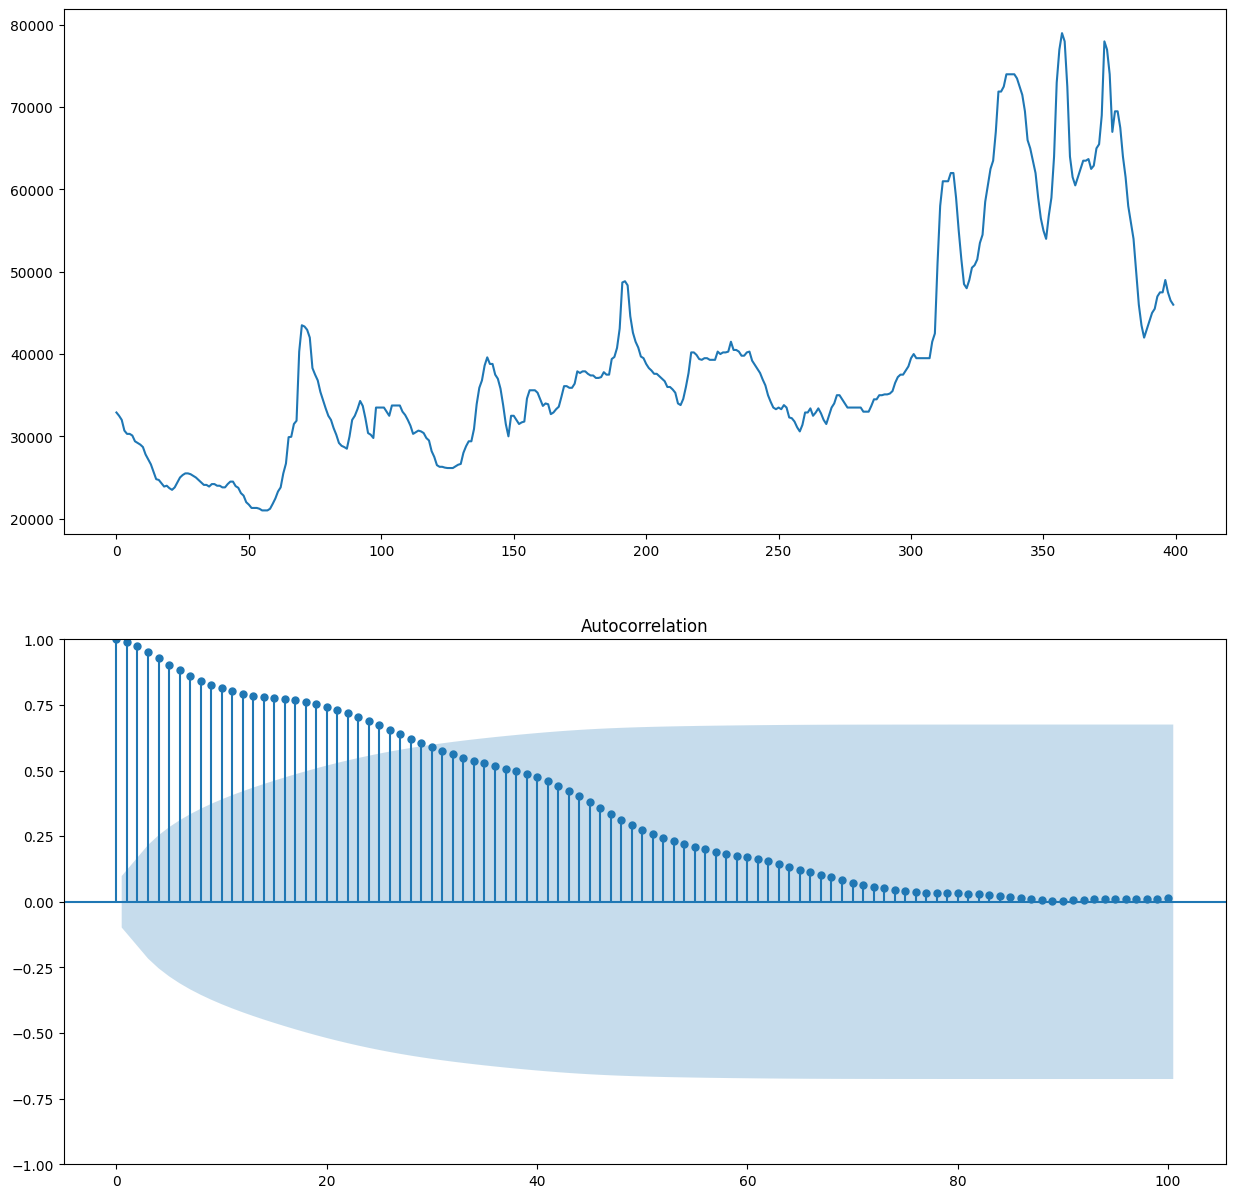

In [ ]:
# Визуализация автокорреляции

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
df_ts['Цена на арматуру'].plot(ax=ax[0])
plot_acf(df_ts['Цена на арматуру'], lags=100, ax=ax[1]);

In [ ]:
# проверка на стационарность первоначального ряда
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена на арматуру'])

ADF Statistic: -1.9258699893713456
p-value: 0.31999061025699155
Critical Values: {'1%': -3.4470566389664703, '5%': -2.8689037160476016, '10%': -2.570692663557422}
Ряд нестационарен (p-value >= 0.05)


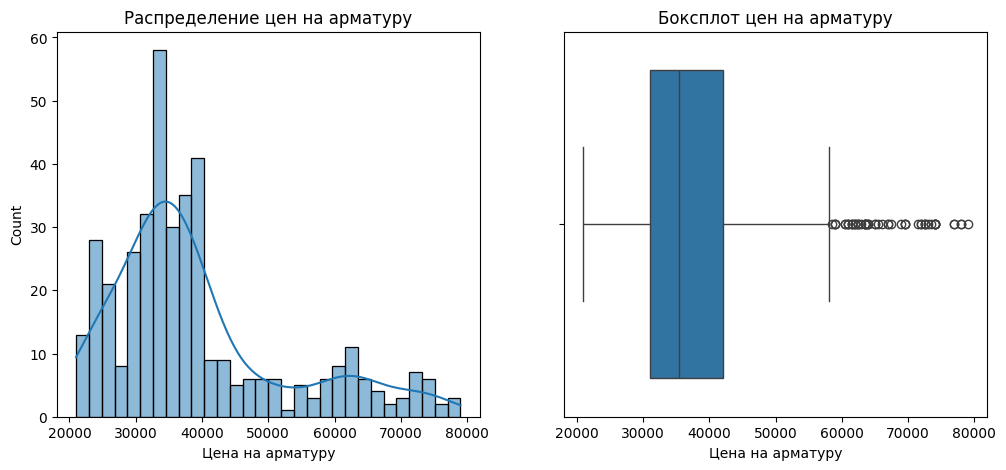

In [ ]:
plt.figure(figsize=(12, 5))

# Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(df_ts["Цена на арматуру"], bins=30, kde=True)
plt.title("Распределение цен на арматуру")

# Боксплот
plt.subplot(1, 2, 2)
sns.boxplot(x=df_ts["Цена на арматуру"])
plt.title("Боксплот цен на арматуру")

plt.show()

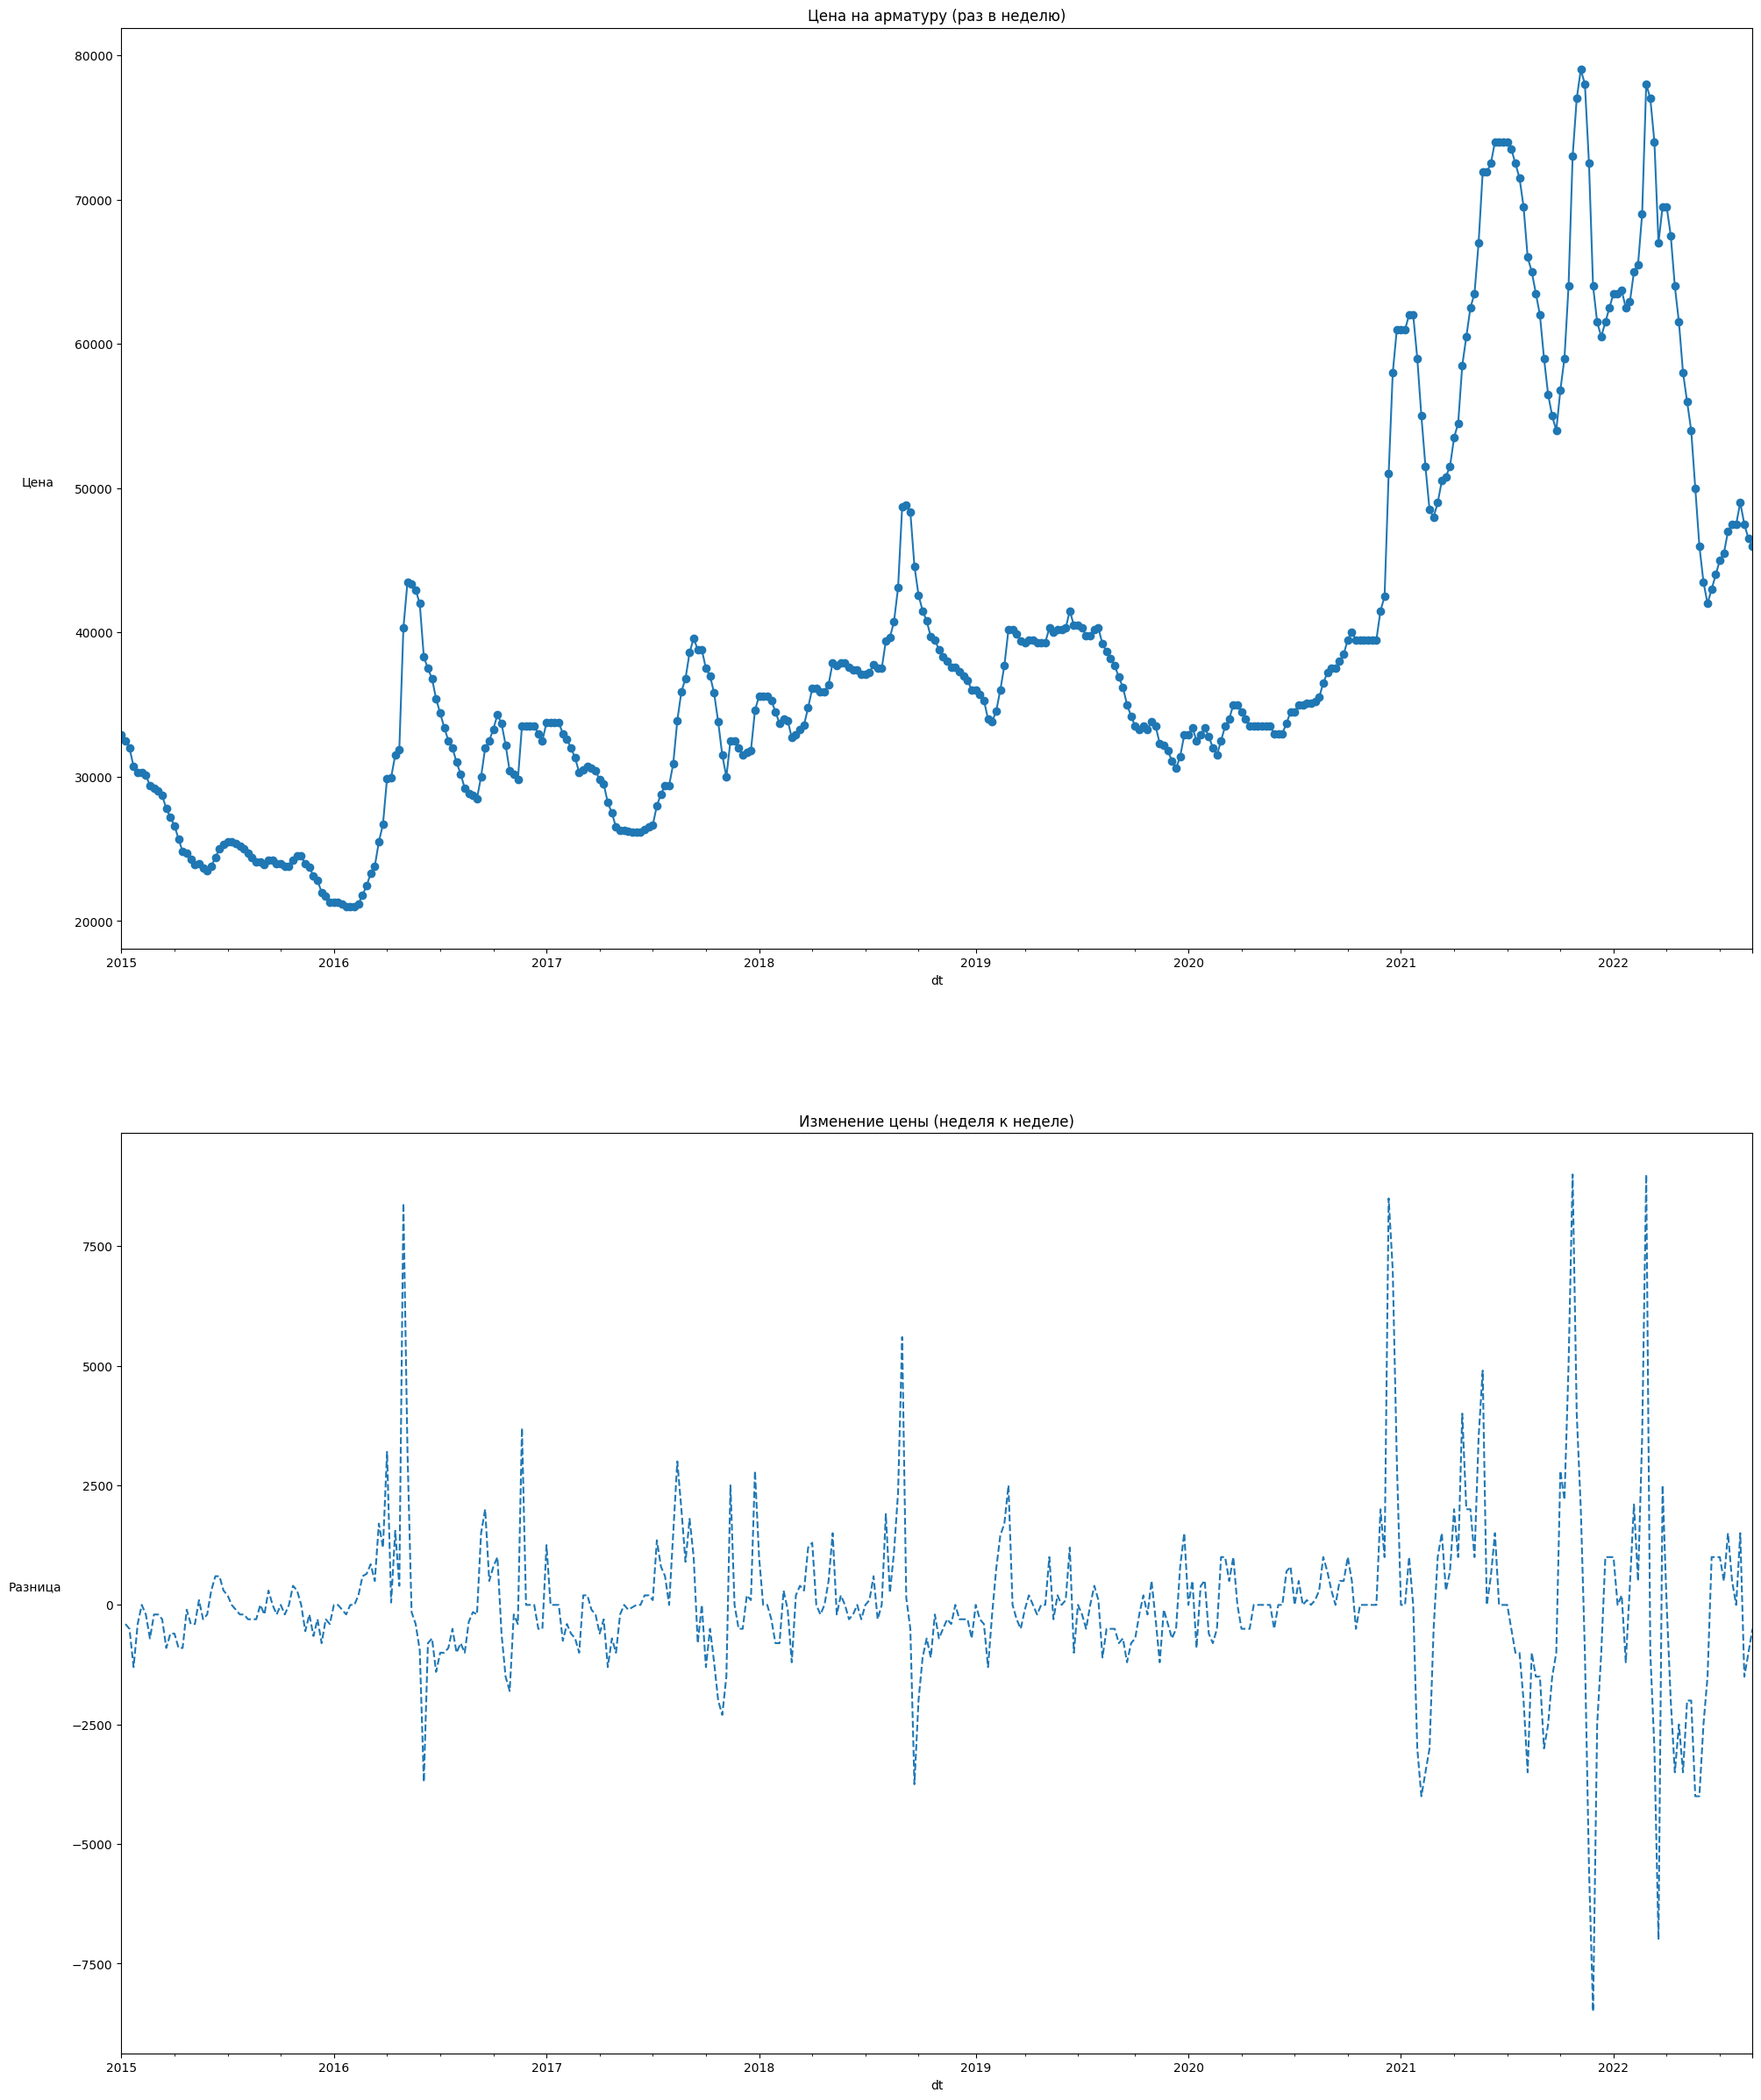

In [ ]:
df_ts['Цена_разница_неделя'] = df_ts['Цена на арматуру'].diff(1)  # Разница с прошлой неделей

plt.figure(figsize=(24, 30))

ax1 = plt.subplot(211)
ax1.set_title('Цена на арматуру (раз в неделю)')
ax1.set_ylabel('Цена', rotation=0, labelpad=30)
df_ts.set_index('dt')['Цена на арматуру'].plot(ax=ax1, marker='o')

ax2 = plt.subplot(212)
ax2.set_title('Изменение цены (неделя к неделе)')
ax2.set_ylabel('Разница', rotation=0, labelpad=30)
df_ts.set_index('dt')['Цена_разница_неделя'].plot(ax=ax2, marker='', linestyle='dashed')

plt.show()

In [ ]:
df_ts.replace(np.nan, 0, inplace=True)

In [ ]:
df_ts.head(10)

,dt,Цена на арматуру,Цена_разница_неделя
0,2015-01-05,32900,0.0
1,2015-01-12,32500,-400.0
2,2015-01-19,32000,-500.0
3,2015-01-26,30700,-1300.0
4,2015-02-02,30300,-400.0
5,2015-02-09,30300,0.0
6,2015-02-16,30100,-200.0
7,2015-02-23,29400,-700.0
8,2015-03-02,29200,-200.0
9,2015-03-09,29000,-200.0


In [ ]:
# проверка на стационарность diff ряда
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена_разница_неделя'])

ADF Statistic: -7.711973437154185
p-value: 1.2568518586885597e-11
Critical Values: {'1%': -3.447360865754795, '5%': -2.8690374364690445, '10%': -2.5707639493486636}
Ряд стационарен (p-value < 0.05)


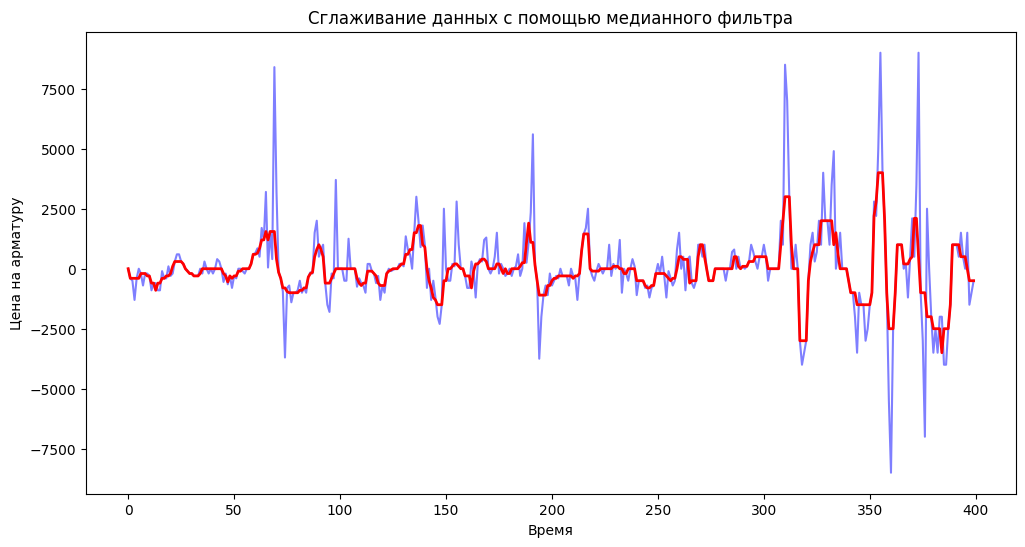

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import medfilt

# Применение медианного фильтра
df_ts["Цена на арматуру (сглаженная)"] = medfilt(df_ts["Цена_разница_неделя"], kernel_size=5)

# Построение графика
plt.figure(figsize=(12, 6))

# Исходные данные
plt.plot(df_ts.index, df_ts["Цена_разница_неделя"], label="Исходные данные", color='blue', alpha=0.5)

# Сглаженные данные
plt.plot(df_ts.index, df_ts["Цена на арматуру (сглаженная)"], label="Сглаженные данные", color='red', linewidth=2)

# Настройка графика
plt.title("Сглаживание данных с помощью медианного фильтра")
plt.xlabel("Время")
plt.ylabel("Цена на арматуру")
plt.show()

In [ ]:
# проверка на стационарность diff ряда после сглаживания
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена на арматуру (сглаженная)'])

ADF Statistic: -7.237213964014841
p-value: 1.9255395178881053e-10
Critical Values: {'1%': -3.44714244478345, '5%': -2.8689414326247995, '10%': -2.5707127699396084}
Ряд стационарен (p-value < 0.05)


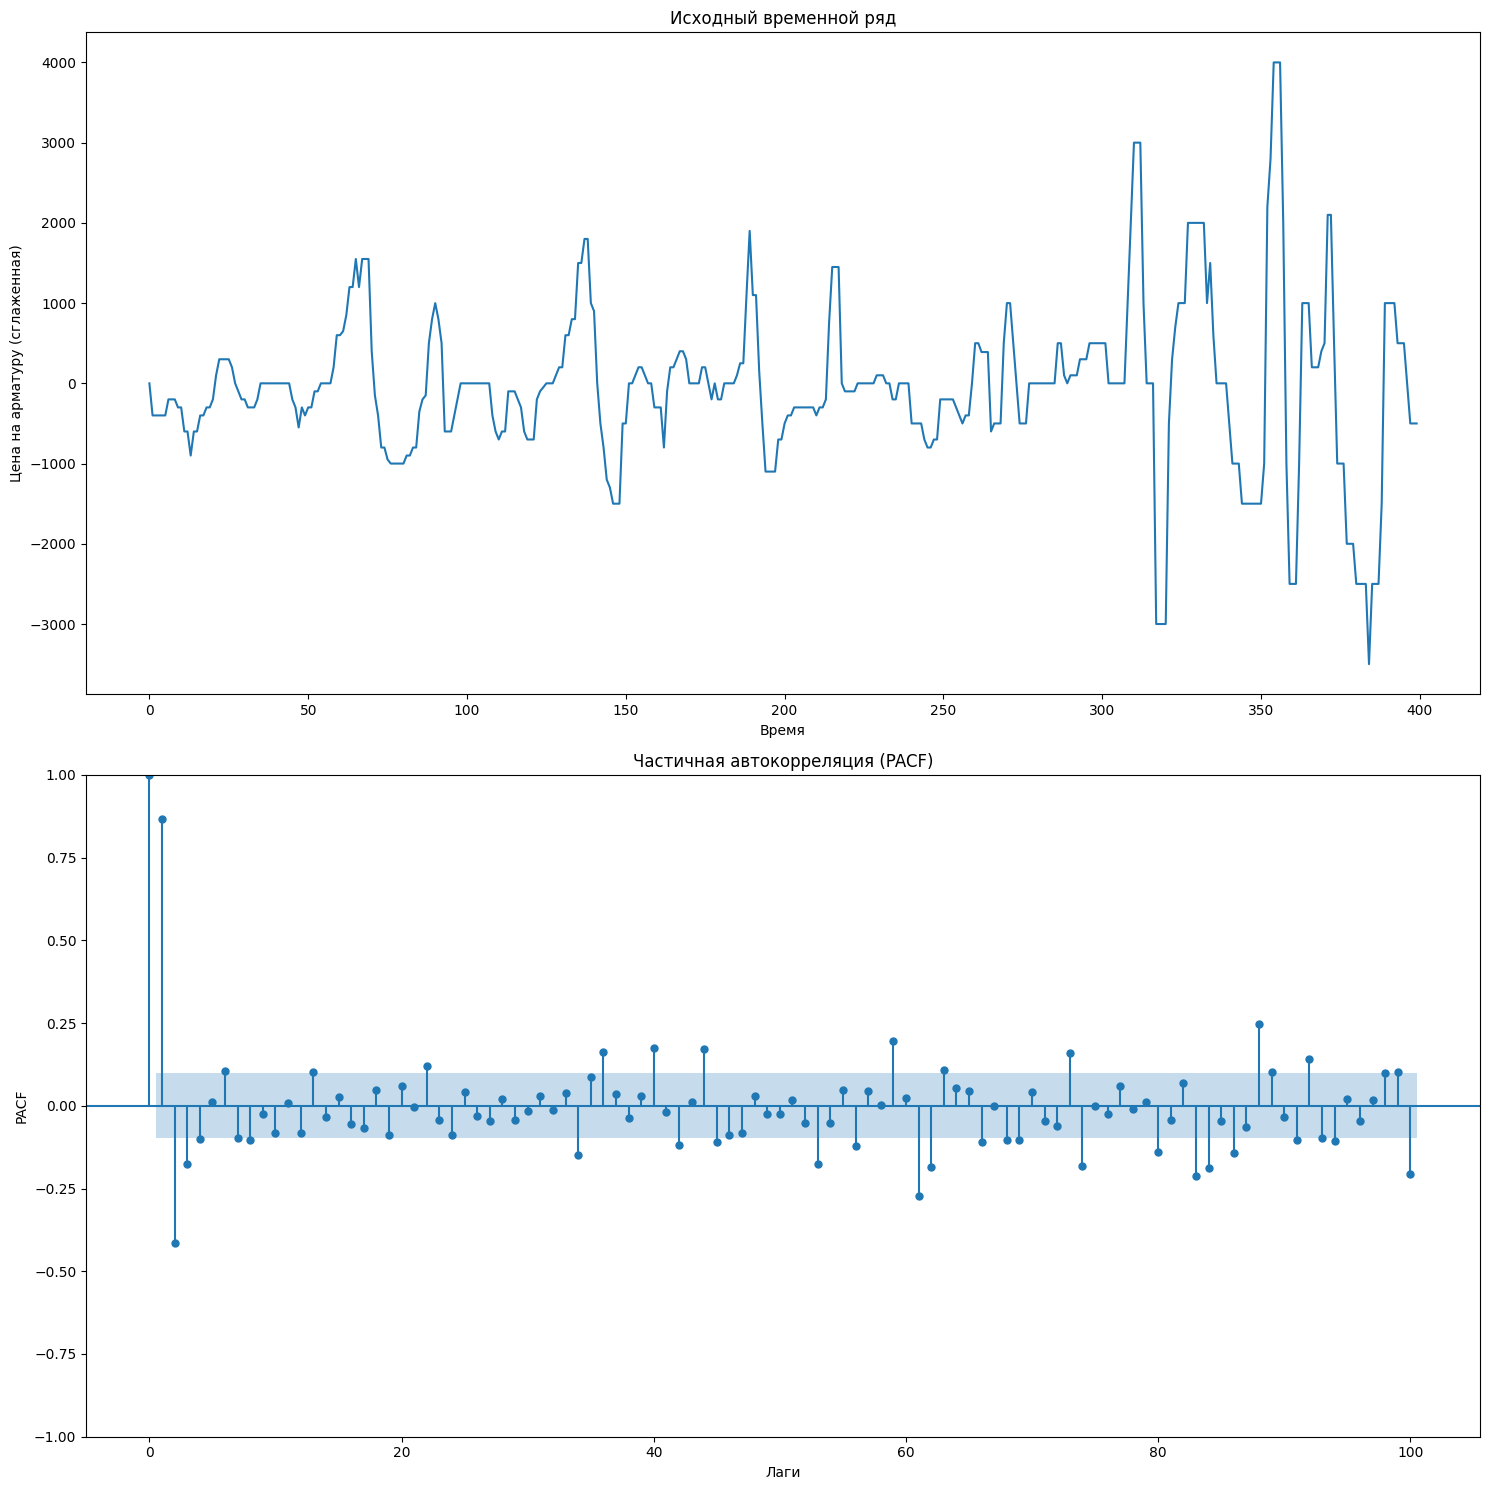

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# Создаем график с двумя подграфиками
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

# Первый подграфик: исходный временной ряд
df_ts['Цена на арматуру (сглаженная)'].plot(ax=ax[0])
ax[0].set_title('Исходный временной ряд')
ax[0].set_xlabel('Время')
ax[0].set_ylabel('Цена на арматуру (сглаженная)')

# Второй подграфик: PACF (частичная автокорреляция)
plot_pacf(df_ts['Цена на арматуру (сглаженная)'], lags=100, ax=ax[1], method='ols')
ax[1].set_title('Частичная автокорреляция (PACF)')
ax[1].set_xlabel('Лаги')
ax[1].set_ylabel('PACF')

# Отображаем график
plt.tight_layout()
plt.show()

# Модели

### Линейная регрессия

Средняя абсолютная ошибка (MAE): 16952.11
Среднеквадратичная ошибка (MSE): 391666297.00
Корень среднеквадратичной ошибки (RMSE): 19790.56
Коэффициент детерминации (R²): -2.7375
Коэффициент (наклон линии): 51.9735
Свободный член (пересечение с осью Y): 25529.88


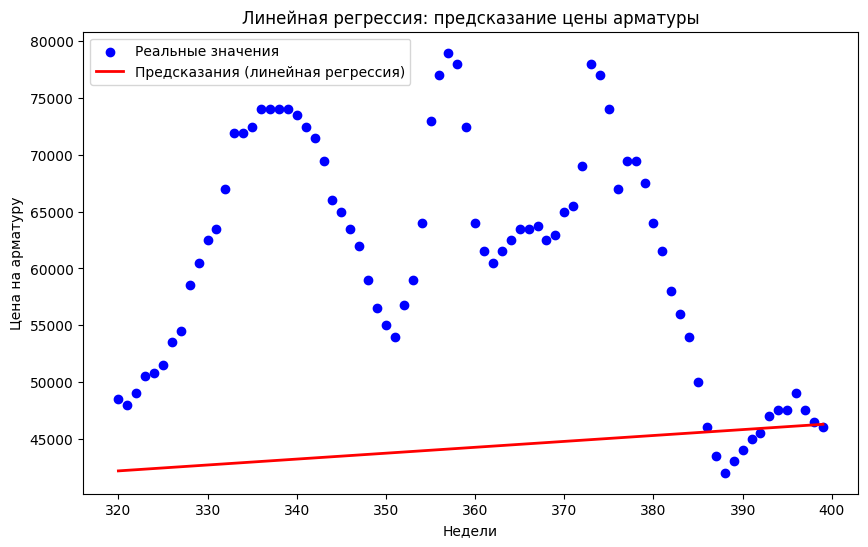

In [ ]:

# 2. Предобработка данных
df_ts["weeks"] = (df_ts["dt"] - df_ts["dt"].min()).dt.days // 7  # Преобразуем дату в количество дней

# 3. Определение признаков (X) и целевой переменной (y)
X = df_ts[["weeks"]]  # Количество недель с первой даты
y = df_ts["Цена на арматуру"]  # Цены на арматуру

# Предположим, X и y уже отсортированы по времени
split_index = int(len(X) * 0.8)

X_train_lr, X_test_lr = X[:split_index], X[split_index:]
y_train_lr, y_test_lr = y[:split_index], y[split_index:]

# 5. Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train_lr, y_train_lr)

# 6. Получение предсказаний
y_pred_lr = model.predict(X_test_lr)

# 7. Оценка качества модели
mae = mean_absolute_error(y_test_lr, y_pred_lr)
mse = mean_squared_error(y_test_lr, y_pred_lr)
rmse = np.sqrt(mse)
r2_score = model.score(X_test_lr, y_test_lr)

# Вывод метрик
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Коэффициент детерминации (R²): {r2_score:.4f}")

# 8. Вывод коэффициентов модели
print(f"Коэффициент (наклон линии): {model.coef_[0]:.4f}")
print(f"Свободный член (пересечение с осью Y): {model.intercept_:.2f}")

# 9. Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(X_test_lr, y_test_lr, color="blue", label="Реальные значения")  # Реальные цены
plt.plot(X_test_lr, y_pred_lr, color="red", linewidth=2, label="Предсказания (линейная регрессия)")  # Линия регрессии
plt.xlabel("Недели")
plt.ylabel("Цена на арматуру")
plt.title("Линейная регрессия: предсказание цены арматуры")
plt.legend()
plt.show()




### Arima

In [ ]:
!pip install --upgrade statsmodels

In [ ]:
from statsmodels.tsa.arima_model import ARIMA  # Для старых версий

In [41]:

# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена на арматуру'])

ADF Statistic: -1.9258699893713456
p-value: 0.31999061025699155
Critical Values: {'1%': -3.4470566389664703, '5%': -2.8689037160476016, '10%': -2.570692663557422}
Ряд нестационарен (p-value >= 0.05)


In [42]:
# Применение первого порядка дифференцирования
df_ts['value_diff'] = df_ts['Цена на арматуру'].diff().dropna()

# Проверка на стационарность
adf_test(df_ts['value_diff'].dropna())

ADF Statistic: -7.706061504115209
p-value: 1.300693837380985e-11
Critical Values: {'1%': -3.447405233596701, '5%': -2.8690569369014605, '10%': -2.5707743450830893}
Ряд стационарен (p-value < 0.05)


In [46]:
# Выбираем столбец с данными временного ряда
time_series = df_ts['value_diff']
model = ARIMA(time_series, order=(4, 0, 3))
fitted_model = model.fit()

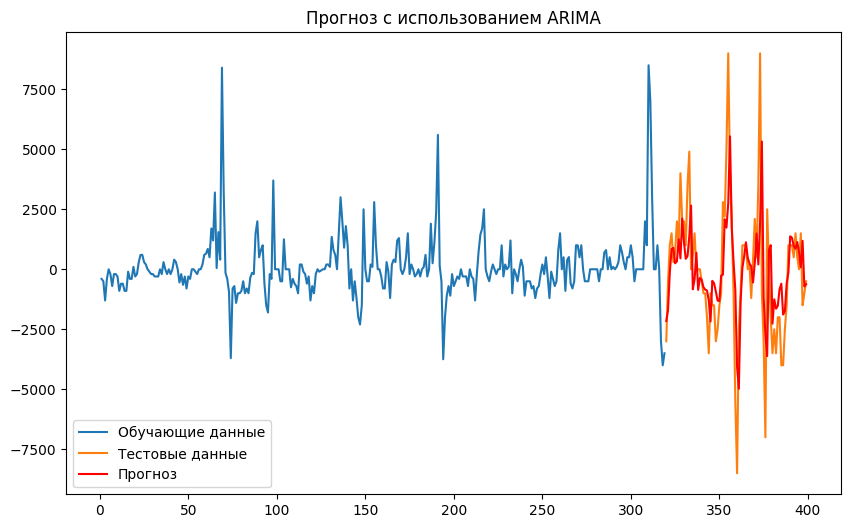

In [47]:
# Прогнозируем на тестовых данных
forecast = fitted_model.predict(start=len(train), end=len(train) + len(test) - 1)

# Визуализируем результат
plt.figure(figsize=(10, 6))
plt.plot(train, label='Обучающие данные')
plt.plot(test, label='Тестовые данные')
plt.plot(forecast, label='Прогноз', color='red')
plt.legend()
plt.title('Прогноз с использованием ARIMA')
plt.show()

### LSTM

In [53]:
# Нормализация данных (LSTM лучше работает с масштабированными данными)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_ts[['Цена на арматуру (сглаженная)']])
df_ts["Цена на арматуру (сглаженная)"] = scaler.fit_transform(df_ts[["Цена на арматуру (сглаженная)"]])

# Разделение на тренировочный и тестовый наборы
train_size = int(len(df_ts) * 0.8)  # 80% на обучение, 20% на тест
train, test = df_ts.iloc[:train_size], df_ts.iloc[train_size:]


In [ ]:
# 4. Создание окон временного ряда
import numpy as np

def create_sequences(df_ts, seq_length):
    X, y = [], []
    for i in range(len(df_ts) - seq_length):
        X.append(df_ts.iloc[i:i+seq_length].values)  # Используем .iloc для работы с DataFrame
        y.append(df_ts.iloc[i+seq_length].values)  # Доступ к следующему значению
    return np.array(X), np.array(y)

# Гиперпараметр: длина окна (количество предыдущих дней, используемых для предсказания)
seq_length = 20

# Проверяем, что столбец существует в DataFrame
if "Цена на арматуру (сглаженная)" not in df_ts.columns:
    raise KeyError("Столбец 'Цена на арматуру (сглаженная)' не найден в df_ts!")

# Выбираем нужный столбец и передаем в функцию
X_train, y_train = create_sequences(df_ts[["Цена на арматуру (сглаженная)"]], seq_length)
X_test, y_test = create_sequences(df_ts[["Цена на арматуру (сглаженная)"]], seq_length)

# Изменение формы для LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# 5. Создание и обучение LSTM-модели

# Построение модели LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Компиляция модели
model.compile(optimizer="adam", loss="mse")

# Обучение модели
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0926 - val_loss: 0.0227
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0245 - val_loss: 0.0193
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0244 - val_loss: 0.0189
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0222 - val_loss: 0.0181
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0213 - val_loss: 0.0177
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0172 - val_loss: 0.0166
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0182 - val_loss: 0.0161
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0155 - val_loss: 0.0156
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0178 - val_loss: 0.0142
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0159 - val_loss: 0.0132
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0156 - val_loss: 0.0138
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE: 300.78
RMSE: 470.29
Общая длина df_ts: 400
train_size: 320, seq_length: 20
Длина df_ts после train_size + seq_length: 60
Размер y_test_inv: (380, 1)
Размер y_pred_inv: (380, 1)
Последние 10 дат в df_ts:
1970-01-01 00:00:00.000000390   2022-06-27
1970-01-01 00:00:00.000000391   2022-07-04
1970-01-01 00:00:00.000000392   2022-07-11
1970-01-01 00:00:00.000000393   2022-07-18
1970-01-01 00:00:00.000000394   2022-07-25
1970-01-01 00:00:00.000000395   2022-08-01
1970-01-01 00:00:00.000000396   2022-08-08
1970-01-01 00:00:00.000000397   2022-08-15
1970-01-01 00:00:00.000000398   2022-08-22
1970-01-01 00:00:00.000000399   2022-08-29
Name: dt, dtype: datetime64[ns]
Первые 10 дат тестового набора:
1970-01-01 00:00:00.000000340   2021-07-12
1970-01-01 00:00:00.000000341   2021-07-19
1970-01-01 00:00:00.000000342   2021-07-26
1970-01-01 00:00:00.000000343   2021-08-02
1970-01-01 00:00:00.000000344   2021-08-09
1970-01-01 00:00:00.000000345   2021-08-16


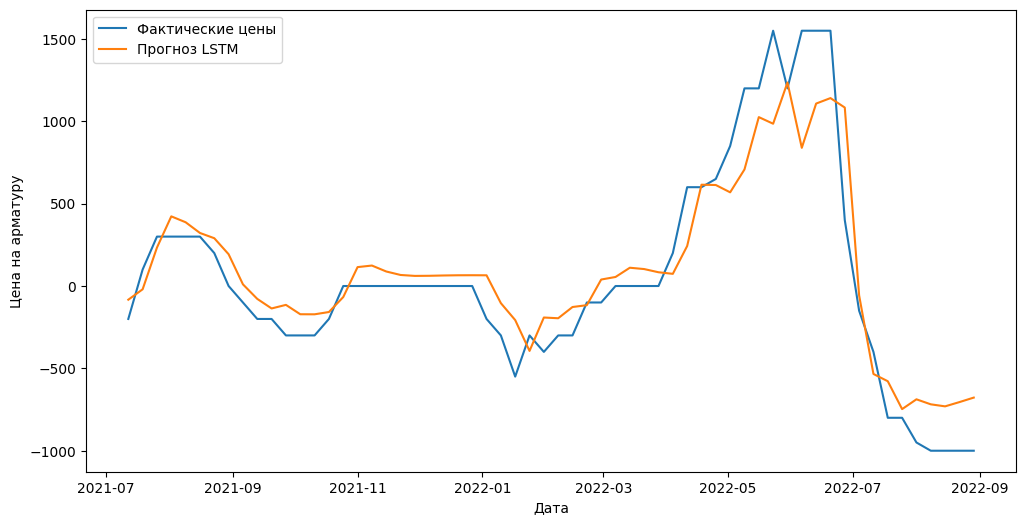

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Предсказания модели
y_pred = model.predict(X_test)

# Обратное масштабирование
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Оценка ошибок
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Проверка размеров данных
print(f"Общая длина df_ts: {len(df_ts)}")
print(f"train_size: {train_size}, seq_length: {seq_length}")
print(f"Длина df_ts после train_size + seq_length: {len(df_ts.iloc[train_size + seq_length:])}")
print(f"Размер y_test_inv: {y_test_inv.shape}")
print(f"Размер y_pred_inv: {y_pred_inv.shape}")

# Проверяем индексы временных меток
print("Последние 10 дат в df_ts:")
print(df_ts["dt"].tail(10))

print("Первые 10 дат тестового набора:")
print(df_ts["dt"].iloc[train_size + seq_length:train_size + seq_length + 10])

# Приведение размеров временных меток и предсказаний к общему минимуму
min_length = min(len(df_ts["dt"].iloc[train_size + seq_length:]), len(y_test_inv))
dates = df_ts["dt"].iloc[train_size + seq_length:train_size + seq_length + min_length]
y_test_inv = y_test_inv[:min_length].flatten()
y_pred_inv = y_pred_inv[:min_length].flatten()

# Визуализация предсказаний
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_inv, label="Фактические цены")
plt.plot(dates, y_pred_inv, label="Прогноз LSTM")
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.legend()
plt.show()



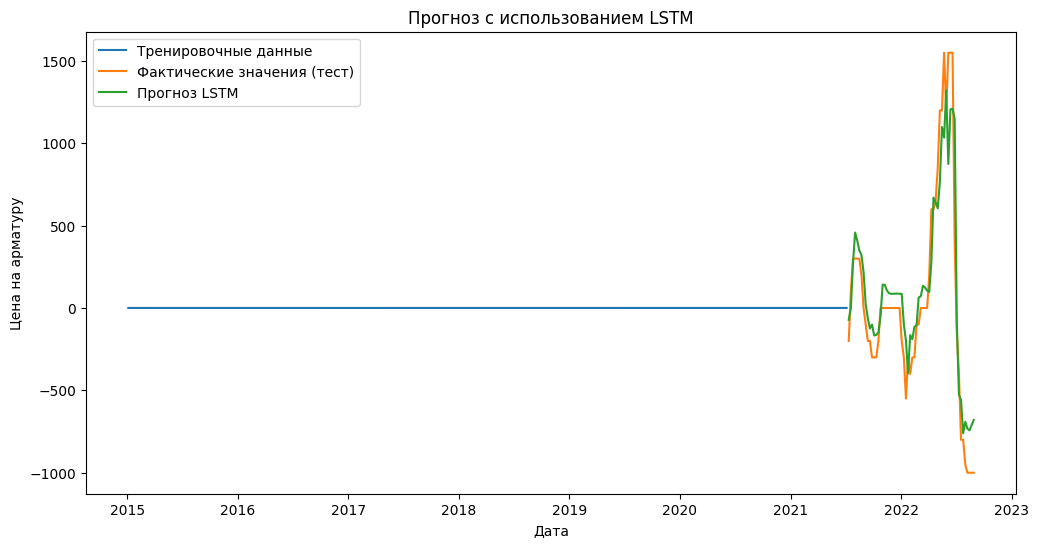

In [56]:
# Подготовка данных для визуализации
train_dates = df_ts['dt'][:train_size + seq_length]
test_dates = df_ts['dt'][train_size + seq_length:train_size + seq_length + len(y_test_inv)]

# Визуализация тренировочных данных, тестовых данных и прогноза
plt.figure(figsize=(12, 6))
plt.plot(train_dates, scaler.inverse_transform(scaled_data[:train_size + seq_length]), label="Тренировочные данные")
plt.plot(test_dates, y_test_inv, label="Фактические значения (тест)")
plt.plot(test_dates, y_pred_inv, label="Прогноз LSTM")
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Прогноз с использованием LSTM")
plt.legend()
plt.show()

### смесь 2 моделй